In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
import matplotlib.pyplot as plt
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.utils import shuffle


In [26]:
df = pd.read_csv("/Volumes/Personal/DS_Code Alpha/Feature-Engineering-Rolling-Stats/predictive_maintenance.csv")


df.drop(["UDI", "Product ID", "Failure Type"], axis=1, inplace=True)

le = LabelEncoder()
df["Type"] = le.fit_transform(df["Type"])  
assert df.isnull().sum().sum() == 0
X = df.drop("Target", axis=1)
y = df["Target"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [27]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


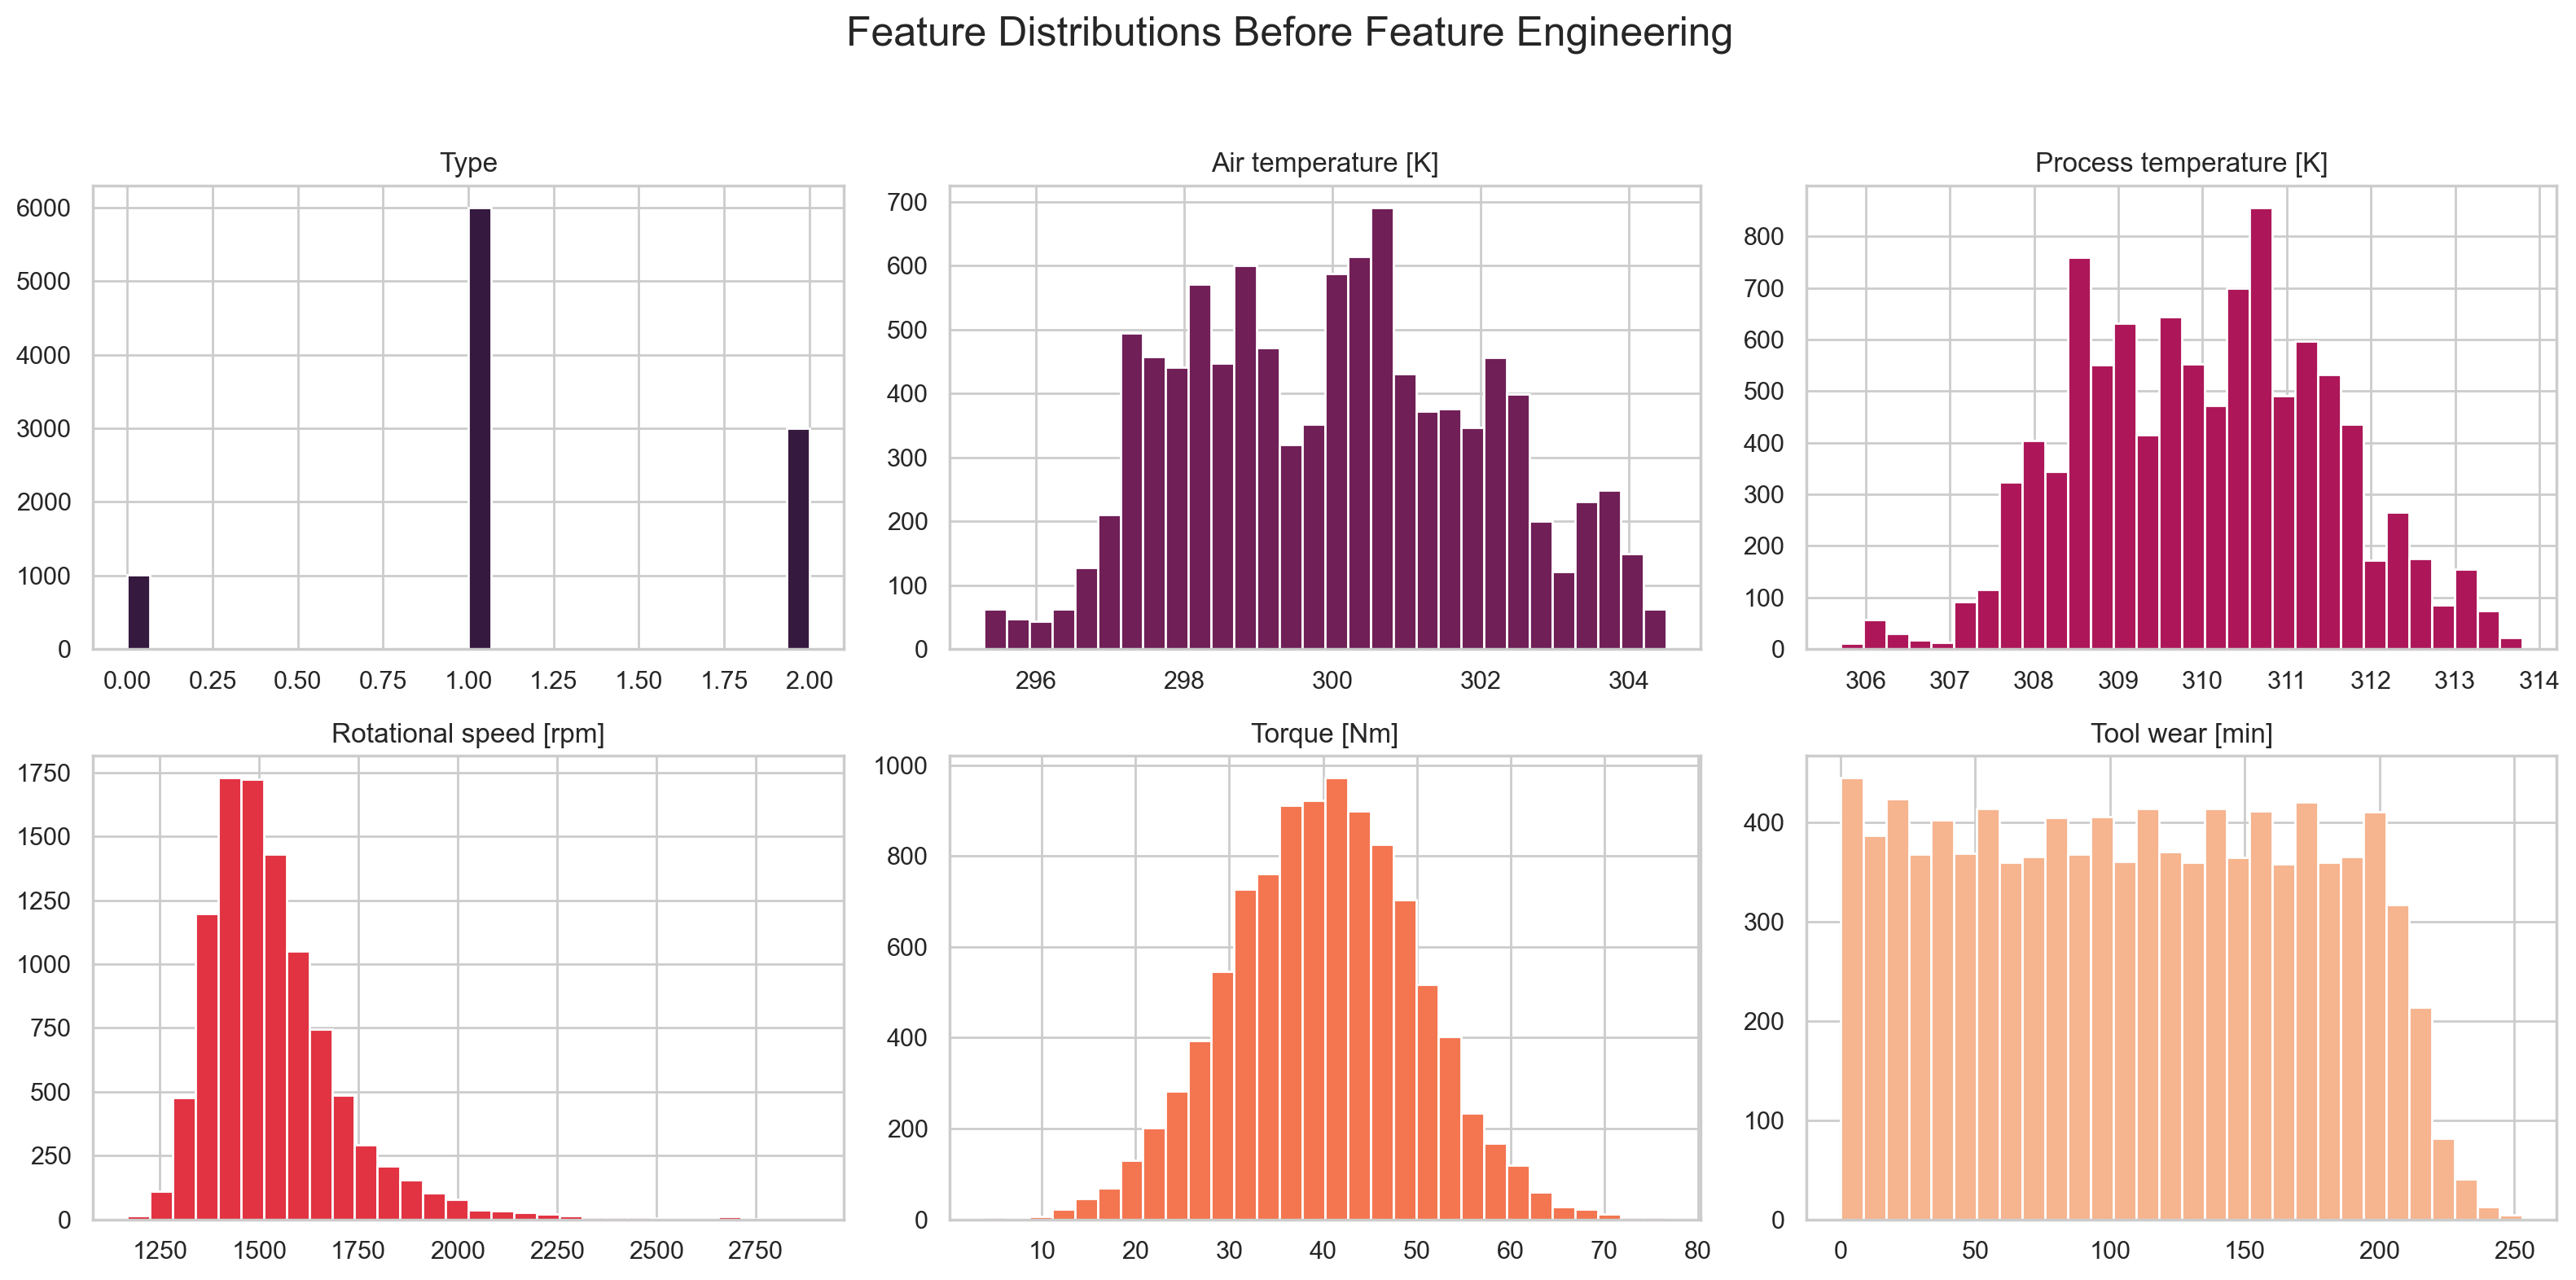

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

selected_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
colors = sns.color_palette("rocket", n_colors=len(selected_columns))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), dpi=200)
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    features_df[col].hist(ax=axes[i], bins=30, color=colors[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.suptitle("Feature Distributions Before Feature Engineering", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test):
    
    gb_clf = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    gb_clf.fit(X_train, y_train)

    y_pred = gb_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    #  ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, gb_clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    return acc, roc_auc, gb_clf, fpr, tpr

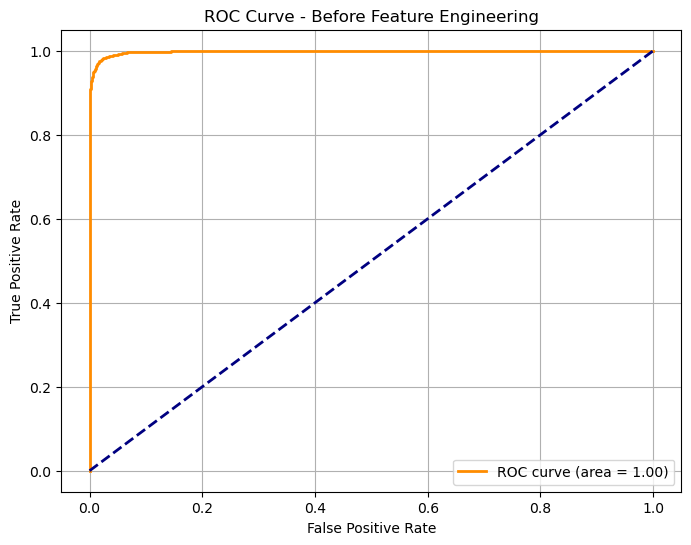

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
acc_before, roc_auc_before, gb_clf_before, fpr_before, tpr_before = evaluate_model(
    X_train, X_test, y_train, y_test
)

#  baseline ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_before)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Before Feature Engineering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Feature Engineering


In [ ]:
# Rolling Statistics (window size = 5)
for col in X_res.columns:
    X_res[f'{col}_roll_mean'] = X_res[col].rolling(window=5).mean()
    X_res[f'{col}_roll_std'] = X_res[col].rolling(window=5).std()

# Lag Features (lags 1 and 2)
for col in X_res.columns[:len(X.columns)]:
    for lag in [1, 2]:
        X_res[f'{col}_lag{lag}'] = X_res[col].shift(lag)

# Domain-specific Interaction Features
X_res["power"] = X_res["Torque [Nm]"] * X_res["Rotational speed [rpm]"]
X_res["wear_torque"] = X_res["Tool wear [min]"] * X_res["Torque [Nm]"]
X_res["temperature_diff"] = X_res["Process temperature [K]"] - X_res["Air temperature [K]"]

# Frequency-Domain Features using FFT
torque_fft = fft(X_res["Torque [Nm]"].fillna(0).to_numpy())
X_res["fft_mean"] = np.mean(np.abs(torque_fft))
X_res["fft_variance"] = np.var(np.abs(torque_fft))

# Dropping NaNs from rolling and lag operations
X_res.dropna(inplace=True)
y_res = y_res.loc[X_res.index]
X_res, y_res = shuffle(X_res, y_res, random_state=42)
X_res.reset_index(drop=True, inplace=True)
y_res.reset_index(drop=True, inplace=True)

# Extracting Time-Series Features with TSFRESH

In [ ]:
# Time series feature extraction using tsfresh
signal_col = "Torque [Nm]"
df_tsfresh = pd.DataFrame({
    "id": np.repeat(np.arange(len(X_res)), 10),
    "time": list(range(10)) * len(X_res),
    "value": np.tile(X_res[signal_col].values, 10)
})


features_extracted = extract_features(df_tsfresh, column_id="id", column_sort="time")
impute(features_extracted)
features_selected = select_features(features_extracted, y_res[:features_extracted.shape[0]])

X_combined = pd.concat([X_res.iloc[:features_selected.shape[0]].reset_index(drop=True),
                        features_selected.reset_index(drop=True)], axis=1)
y_combined = y_res.iloc[:features_selected.shape[0]].reset_index(drop=True)

Feature Extraction: 100%|██████████| 25/25 [00:57<00:00,  2.32s/it]
/Users/chintubharath/tensorflow-metal/env/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__partial_autocorrelation__lag_5'
 'value__partial_autocorrelation__lag_6'
 'value__partial_autocorrelation__lag_7'
 'value__partial_autocorrelation__lag_8'
 'value__partial_autocorrelation__lag_9'
 'value__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)'
 'value__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10,

# Model Evaluation After Feature Engineering


After Feature Engineering:
✅ Accuracy: 0.9943
✅ ROC AUC: 0.9988
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       1.00      0.99      0.99      1932

    accuracy                           0.99      3864
   macro avg       0.99      0.99      0.99      3864
weighted avg       0.99      0.99      0.99      3864

🔍 Confusion Matrix:
 [[1925    7]
 [  15 1917]]


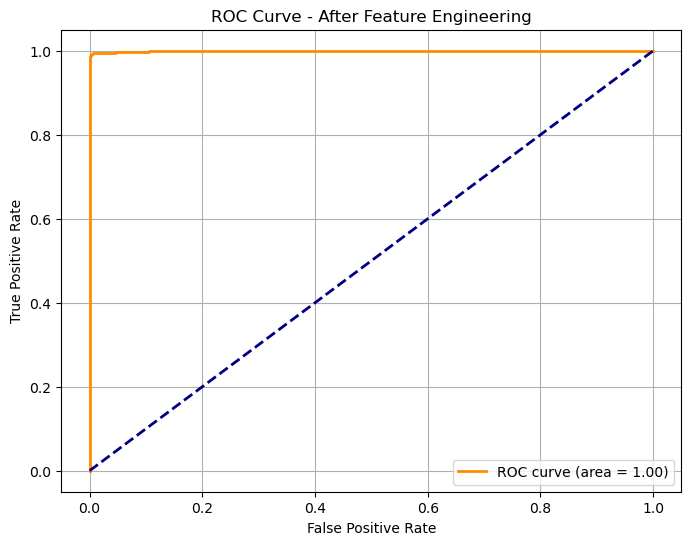

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)
acc_after, roc_auc_after, gb_clf_after, fpr_after, tpr_after = evaluate_model(
    X_train, X_test, y_train, y_test
)
#  evaluation summary
print(f"\nAfter Feature Engineering:")
print(f" Accuracy: {acc_after:.4f}")
print(f" ROC AUC: {roc_auc_after:.4f}")
print("📊 Classification Report:\n", classification_report(y_test, gb_clf_after.predict(X_test)))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, gb_clf_after.predict(X_test)))

#  ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_after, tpr_after, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_after)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - After Feature Engineering')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Spectral Energy Visualization (FFT)

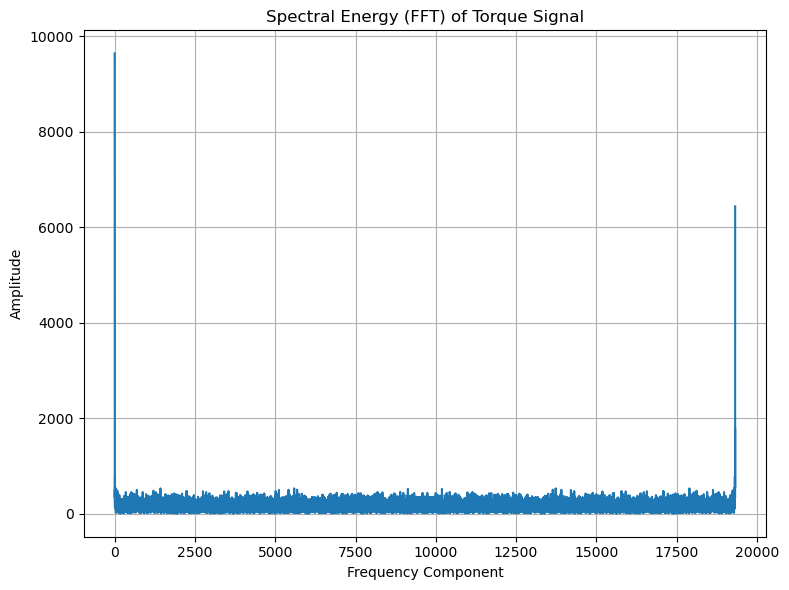

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(np.abs(torque_fft))
plt.title('Spectral Energy (FFT) of Torque Signal')
plt.xlabel('Frequency Component')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

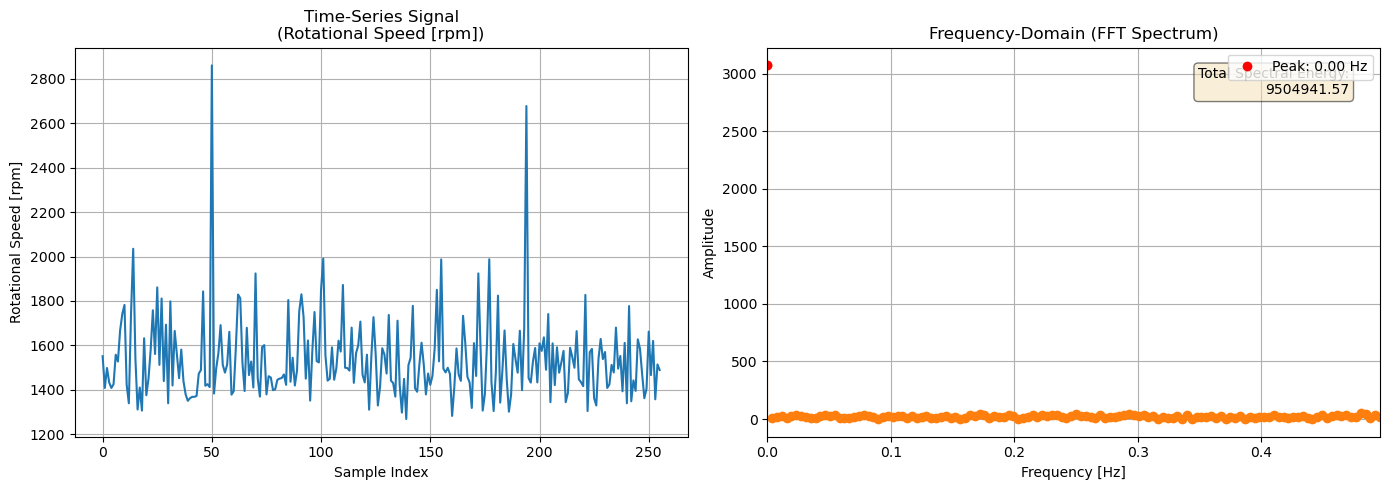

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


df = pd.read_csv("/Volumes/Personal/DS_Code Alpha/Feature-Engineering-Rolling-Stats/predictive_maintenance.csv")
signal = df['Rotational speed [rpm]'].values[:256]


fs = 1  

# Compute FFT
N = len(signal)
yf = fft(signal)
xf = fftfreq(N, 1/fs)[:N//2]  # positive frequencies


fft_magnitude = 2.0/N * np.abs(yf[0:N//2])

#  dominant frequency peak
peak_idx = np.argmax(fft_magnitude)
peak_freq = xf[peak_idx]
peak_magnitude = fft_magnitude[peak_idx]

#  total spectral energy
spectral_energy = np.sum(fft_magnitude**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time-domain plot
ax1.plot(signal, color='tab:blue')
ax1.set_title('Time-Series Signal\n(Rotational Speed [rpm])')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Rotational Speed [rpm]')
ax1.grid(True)

# Frequency-domain plot
ax2.stem(xf, fft_magnitude, linefmt='C1-', markerfmt='C1o', basefmt=" ")
ax2.plot(peak_freq, peak_magnitude, 'ro', label=f'Peak: {peak_freq:.2f} Hz')
ax2.set_xlim(0, np.max(xf))
ax2.set_title('Frequency-Domain (FFT Spectrum)')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)
textstr = f'Total Spectral Energy:\n{spectral_energy:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


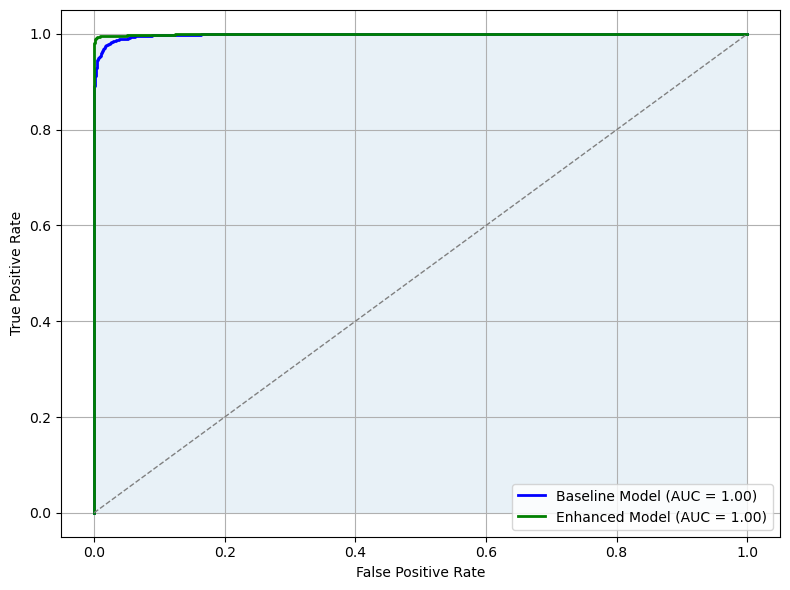

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, color='blue', lw=2, label=f'Baseline Model (AUC = {roc_auc_before:.2f})')
plt.plot(fpr_after, tpr_after, color='green', lw=2, label=f'Enhanced Model (AUC = {roc_auc_after:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.fill_between(fpr_after, 0, tpr_after, alpha=0.1) 


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Figure 2: ROC Curves Comparing Baseline and Enhanced Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Figure 2 (below) displays the ROC curves of the two models. The enhanced model’s curve is much closer to the upper-left corner (higher true positive rate for any false positive rate), reflecting its superior discrimination. The area under the curve (AUC) increased dramatically with feature engineering.
Figure 2: ROC curves comparing the baseline model (blue) and the enhanced model (green) after feature engineering. The improved model achieves a larger area under the curve (shaded), indicating higher overall predictive accuracy.

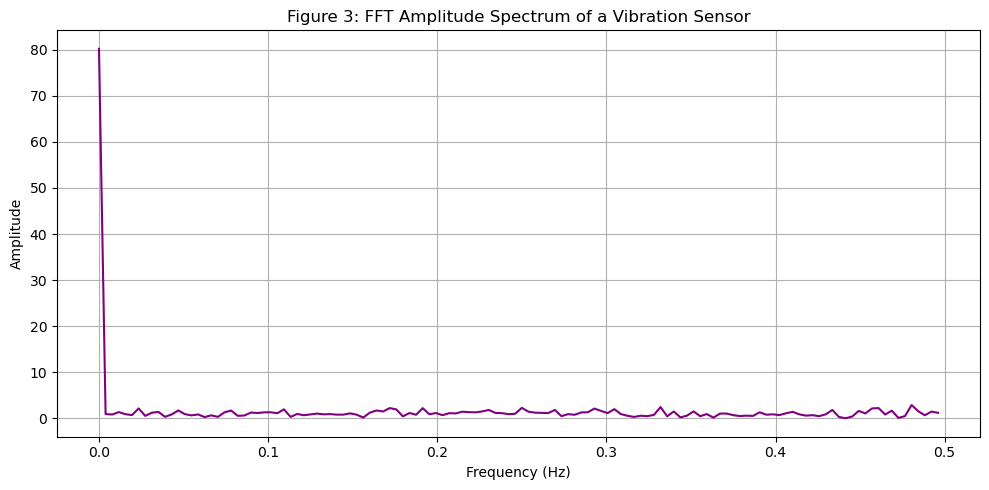

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


df = pd.read_csv("/Volumes/Personal/DS_Code Alpha/Feature-Engineering-Rolling-Stats/predictive_maintenance.csv")


signal = df["Torque [Nm]"].values[:256]  
Fs = 1.0  # Hz
N = len(signal)
T = 1.0 / Fs

# FFT computation
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]
amplitude = 2.0/N * np.abs(yf[0:N//2])

#  FFT amplitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(xf, amplitude, color='purple')
plt.title('Figure 3: FFT Amplitude Spectrum of a Vibration Sensor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()
